In [13]:
import kagglehub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [14]:
data = kagglehub.dataset_download("jcacperalta/senators-of-the-philippines-1st-to-18th-congress")
print("Path to dataset files:", data)

files = os.listdir(data)

Path to dataset files: /root/.cache/kagglehub/datasets/jcacperalta/senators-of-the-philippines-1st-to-18th-congress/versions/4


## Dataset Review

In [15]:
file_path = os.path.join(data, files[0])
df = pd.read_csv(file_path)

df.head()

,congress_number,congress_start_year,position,last_name,first_name,middle_initial,nickname,suffix,birthday,birthplace,residence
0,19,2022,Senator,Angara,Juan Edgardo,M,Sonny,NaN,7/15/1972,Manila,Aurora
1,19,2022,Senator,Ejercito,Joseph Victor,G,JV,NaN,12/26/1969,San Juan City,San Juan City
2,19,2022,Senator,Escudero,Francis Joseph,G,Chiz,NaN,10/10/1969,Sorsogon Sorsogon,NaN
3,19,2022,Senator,Tolentino,Francis,N,Tol,NaN,1/3/1960,Albay,Tagaytay City
4,19,2022,Senator,Pimentel,Aquilino,NaN,Koko,III,1/20/1964,Cagayan de Oro,Cagayan de Oro


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   congress_number      482 non-null    int64 
 1   congress_start_year  482 non-null    int64 
 2   position             482 non-null    object
 3   last_name            482 non-null    object
 4   first_name           482 non-null    object
 5   middle_initial       439 non-null    object
 6   nickname             230 non-null    object
 7   suffix               87 non-null     object
 8   birthday             482 non-null    object
 9   birthplace           477 non-null    object
 10  residence            472 non-null    object
dtypes: int64(2), object(9)
memory usage: 41.6+ KB


In [17]:
df["congress_start_year"].describe()

,congress_start_year
count,482.000000
mean,1985.917012
std,25.409686
min,1946.000000
25%,1962.000000
50%,1992.000000
75%,2007.000000
max,2022.000000


## Visualization

In [156]:
def get_birthyear(x):
    if '/' in x:
        return pd.to_datetime(x).year
    else:
        return int(x)

df['birthyear'] = df['birthday'].apply(lambda x: get_birthyear(x))
df['age_elected'] = (df['congress_start_year'] - df['birthyear']).astype(int)

In [157]:
generation_dict = {
    "Revolutionary Generation": (1860, 1882, '#909495'),
    "Lost Generation": (1883, 1899, '#BCE8F1'),
    "Greatest generation": (1900, 1924, '#2A627D'),
    "Silent generation": (1925, 1945, '#039DFF'),
    "Baby boomers": (1946, 1964, '#90EE90'),
    "Generation X": (1965, 1979, '#ACD03A'),
    "Millennials": (1980, 2021, '#FE18A3')
}

In [158]:
def assign_generation(year):
    for gen, (start, end, _) in generation_dict.items():
        if start <= year <= end:
            return gen

    return "Unknown"

df['generation'] = df['birthyear'].sort_values(ascending=False).apply(assign_generation)
#df = df.sort_values(by=['birthyear'], ascending=True)
df['senator_number'] = df.groupby(['congress_number']).cumcount(ascending=False) + 1

In [159]:
gen_order = list(generation_dict.keys())  # Sorted order for heatmap
gen_palette = {gen: color for gen, (_, _, color) in generation_dict.items()}

df['generation'] = pd.Categorical(df['generation'], categories=gen_order, ordered=True)
df_sorted = df.sort_values(by=['congress_start_year', 'generation'])

# Pivot table for heatmap
df_pivot = df_sorted.pivot(index='senator_number',
                           columns='congress_start_year',
                           values='generation')


# Create a mapping where the first generation starts at 0
gen_index_mapping = {gen: i for i, gen in enumerate(gen_order)}

# Convert generations to numeric values (starting from 0)
df_pivot_numeric = df_pivot.applymap(lambda x: float(gen_index_mapping[x]) if x in gen_index_mapping else np.nan)

df_pivot_numeric = df_pivot_numeric.astype(float)

<ipython-input-159-df97e9c09e5e>:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pivot_numeric = df_pivot.applymap(lambda x: float(gen_index_mapping[x]) if x in gen_index_mapping else np.nan)


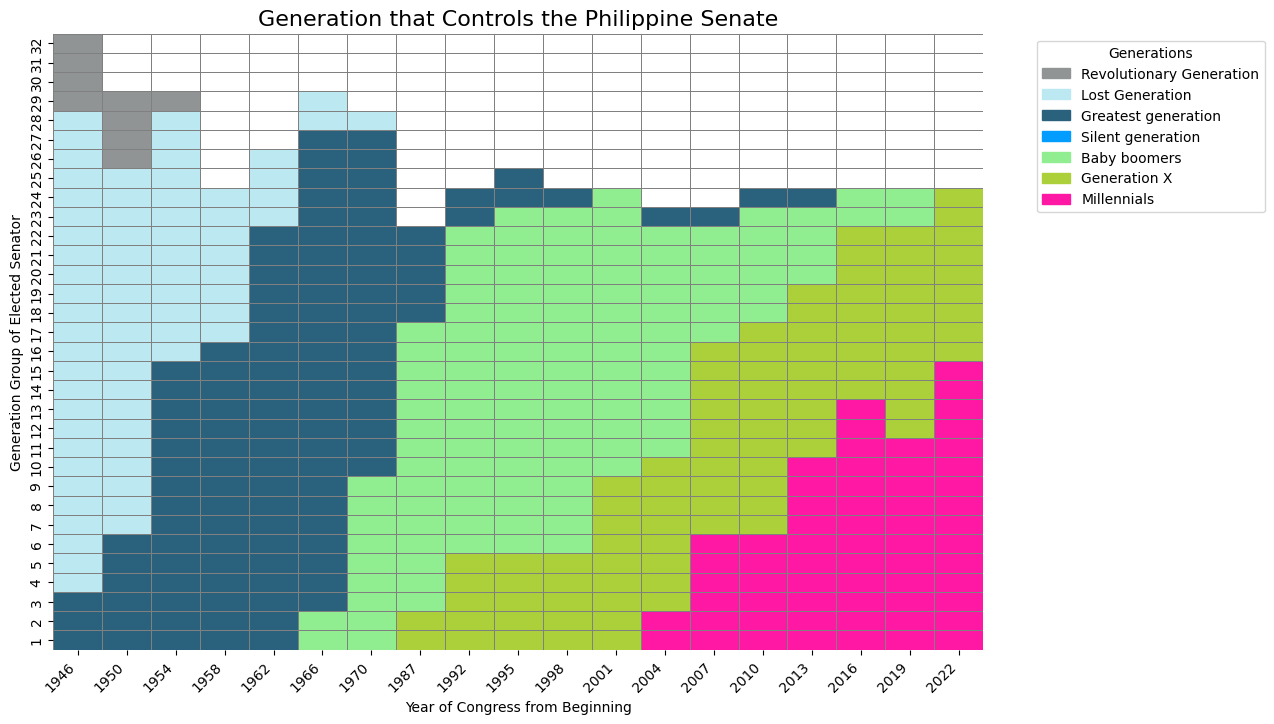

In [160]:
import numpy as np

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    df_pivot_numeric,
    cmap=[gen_palette[gen] for gen in gen_order],
    cbar=False, linewidths=0.5, linecolor='gray'
)
plt.gca().invert_yaxis()
plt.xticks(rotation=45, ha='right')
plt.xlabel("Year of Congress from Beginning")
plt.ylabel("Generation Group of Elected Senator")
plt.title("Generation that Controls the Philippine Senate", fontsize=16)

# Legend
from matplotlib.patches import Patch
legend_patches = [Patch(color=gen_palette[gen], label=gen) for gen in gen_order]
plt.legend(handles=legend_patches, title="Generations", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()